# RQ1
https://docs.google.com/document/d/1a_6lp-0RcdGTYWP4wBq3WuaPgDrjyvGIfMbyZjm9Z_U/edit?usp=sharing


In [1]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import platform


In [3]:
# suppress annoying warnings
pd.options.mode.chained_assignment = None

In [4]:
# change current working directory to content root
if platform.system() == 'Windows':
    os.chdir('..\\..')
    # check that this worked out
    assert os.getcwd().split('\\')[-1] == 'immun-ml'
else:
    os.chdir('../..')
    # check that this worked out
    assert os.getcwd().split('/')[-1] == 'immun-ml'

In [5]:
# local imports
from src.d00_helpers import helpers as h

In [6]:
# read in dataset
johannes_path = '/Users/johannesallgaier/Library/CloudStorage/GoogleDrive-johannes.allgaier@ikeb-wuerzburg.com/My Drive/23-12-06_Immun-ML/04_Data/00_raw/2024.02.12_Mastertable.xlsx'
df = pd.read_excel(johannes_path)

## Target 1: `SARS-IgG`

In [7]:
sars_igg_columns = [col for col in df.columns if 'SARS-IgG' in col and not 'dicho' in col]
target_df = df[['ID'] + sars_igg_columns]
target_df.dropna(how='all', inplace=True)
target_df.set_index('ID',inplace=True)
target_df.loc[:,'non_null_count'] = target_df.notnull().sum(axis=1)
print('How many SARS-IgG values do we have per patient?')
target_df['non_null_count'].describe()

How many SARS-IgG values do we have per patient?


count    328.000000
mean       7.307927
std        5.027721
min        0.000000
25%        3.000000
50%        5.000000
75%       12.000000
max       17.000000
Name: non_null_count, dtype: float64

**The variable SARS-IgG seems to be very sparse with 6 measurements per patient +/- 6 values. Some patients do not have any measurements and one patient has 20 measurements.**

### Check Date Ranges for Entnahme_T{i}

In [8]:
date_cols = [col for col in df.columns if 'Entnahme' in col]

df[date_cols].describe().loc[['min', 'max'], :]

,Entnahme_T0,Entnahme_T1,Entnahme_T2,Entnahme_T3,Entnahme_T4,Entnahme_T12,Entnahme_T13,Entnahme_T14,Entnahme_T15,Entnahme_T16,...,Entnahme_T21e,Entnahme_T22,"Entnahme_T22,5",Entnahme_T23,Entnahme_T24,Entnahme_T25,Entnahme_Tb,Entnahme_T31e,Entnahme_T32,"Entnahme_T32,5"
min,2021-02-16 00:00:00,2021-03-02 00:00:00,2021-02-18 00:00:00,2021-04-26 00:00:00,2021-08-02 00:00:00,2021-01-11 00:00:00,2021-12-13 00:00:00,2022-02-22 00:00:00,2022-06-27 00:00:00,2022-10-03 00:00:00,...,2022-10-24 00:00:00,2022-04-11 00:00:00,2022-12-13 00:00:00,2022-05-16 00:00:00,2022-08-08 00:00:00,2022-11-10 00:00:00,2022-10-24 00:00:00,2022-10-24 00:00:00,2022-11-09 00:00:00,2022-12-12 00:00:00
max,2021-02-16 00:00:00,2021-07-29 00:00:00,2021-11-05 00:00:00,2021-12-21 00:00:00,2021-11-26 00:00:00,2022-02-14 00:00:00,2022-04-13 00:00:00,2022-06-23 00:00:00,2022-07-28 00:00:00,2022-12-22 00:00:00,...,2022-12-09 00:00:00,2023-01-04 00:00:00,2023-01-09 00:00:00,2023-01-09 00:00:00,2022-11-10 00:00:00,2023-01-09 00:00:00,2022-11-04 00:00:00,2022-11-30 00:00:00,2022-12-22 00:00:00,2023-01-11 00:00:00


### Find specific dates of target values instead of T1, T2, ...

In [81]:
time_points = [date_col.split('_')[-1] for date_col in date_cols]
sars_melted = pd.melt(df, id_vars='ID', value_vars=[f'SARS-IgG_{i}' for i in time_points if i != 'T22,5'],
                      var_name='SARS-IgG', value_name='SARS-IgG_Value')

In [82]:
sars_melted['Date'] = None

for idx in sars_melted.index:
    ID = sars_melted.loc[idx, 'ID']
    Time = sars_melted.loc[idx, 'SARS-IgG'].split('_')[-1]
    try:
        sars_melted.loc[idx, 'Date'] = df[df['ID']==ID][f'Entnahme_{Time}'].iloc[0]
    except:
        print(f'Error for ID {ID} and Time {Time}')

# drop row if SARS-IgG_Value is NaN
sars_melted  = sars_melted[sars_melted['SARS-IgG_Value'].notna()]

sars_melted.Date = pd.to_datetime(sars_melted.Date)

In [83]:
# how many missing values for measuring date?
sars_melted.sort_values(by=['ID','Date']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 2279 entries, 123 to 1728
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              2279 non-null   object        
 1   SARS-IgG        2279 non-null   object        
 2   SARS-IgG_Value  2279 non-null   float64       
 3   Date            2279 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 89.0+ KB


Around 500. This is too much. How about a median date missing value treatment?

### Missing value treatment for date column

In [84]:
for date_col in date_cols:
    df = h.replace_with_median(df, date_col)

    sars_melted['Date'] = None

for idx in sars_melted.index:
    ID = sars_melted.loc[idx, 'ID']
    Time = sars_melted.loc[idx, 'SARS-IgG'].split('_')[-1]
    try:
        sars_melted.loc[idx, 'Date'] = df[df['ID']==ID][f'Entnahme_{Time}'].iloc[0]
    except:
        print(f'Error for ID {ID} and Time {Time}')

# drop row if SARS-IgG_Value is NaN
sars_melted  = sars_melted[sars_melted['SARS-IgG_Value'].notna()]

# convert date to Datetime
sars_melted.Date = pd.to_datetime(sars_melted.Date)

# how many missing values for measuring date?
sars_melted.sort_values(by=['ID','Date']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 2279 entries, 123 to 1728
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              2279 non-null   object        
 1   SARS-IgG        2279 non-null   object        
 2   SARS-IgG_Value  2279 non-null   float64       
 3   Date            2279 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 89.0+ KB


In [85]:
# separate HD and control group
sars_melted['Group'] = None
sars_melted['Group'] =sars_melted['ID'].apply(lambda x: 'HD' if 'HD' in x else 'C')

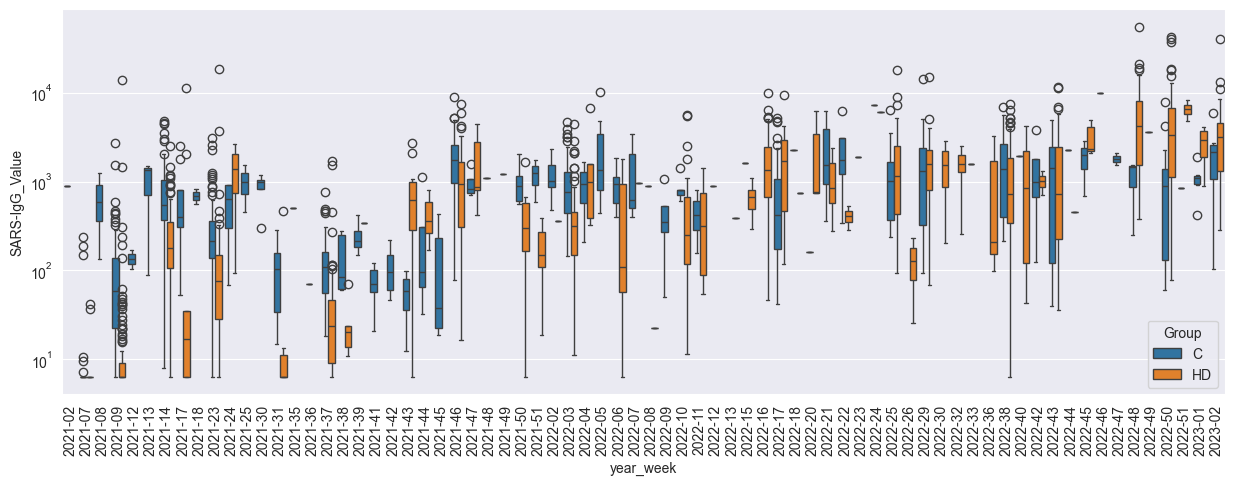

In [86]:
plt.figure(figsize=(15, 5))

sars_melted['year_week'] = sars_melted['Date'].dt.strftime('%Y-%U')
sars_melted = sars_melted.sort_values(by='year_week', ascending=True)
g = sns.boxplot(data=sars_melted, x = 'year_week', y ='SARS-IgG_Value', hue='Group')
g.set_yscale("log")

plt.xticks(rotation=90)

plt.show()

### Issue: Small values for SARS-IgG after Treament

In [105]:
sars_melted[sars_melted['SARS-IgG_Value']<10]

,ID,SARS-IgG,SARS-IgG_Value,Date,Group,year_week
0,HD1,SARS-IgG_T0,6.3,2021-02-16,HD,2021-07
146,C30,SARS-IgG_T0,6.3,2021-02-16,C,2021-07
147,C31,SARS-IgG_T0,6.3,2021-02-16,C,2021-07
149,C33,SARS-IgG_T0,6.3,2021-02-16,C,2021-07
150,C34,SARS-IgG_T0,6.3,2021-02-16,C,2021-07
...,...,...,...,...,...,...
1408,HD108,SARS-IgG_T4,6.3,2021-09-15,HD,2021-37
1732,HD103,SARS-IgG_T12,6.3,2021-10-26,HD,2021-43
2060,HD103,SARS-IgG_T13,6.3,2021-12-14,HD,2021-50
2077,HD122,SARS-IgG_T13,6.3,2022-02-08,HD,2022-06


<Figure size 1500x500 with 0 Axes>

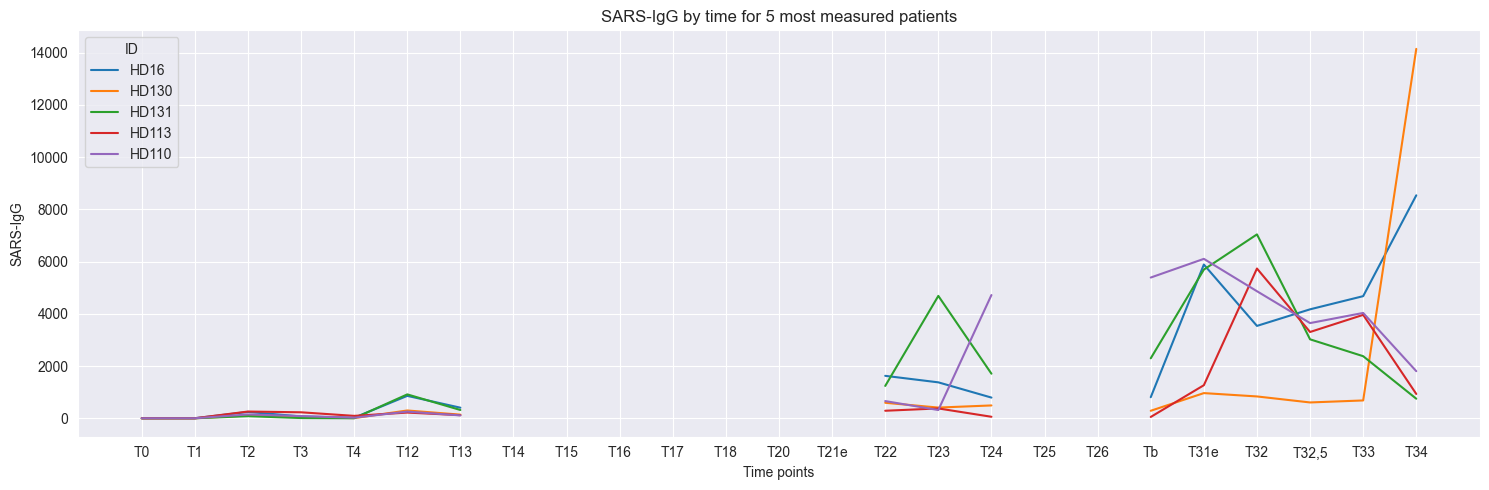

In [104]:
target_df = target_df.sort_values(by='non_null_count', ascending=False)

plt.figure(figsize=(15, 5))

sub_df=target_df.iloc[:5, :-1].T

ax = sub_df.plot(kind='line', figsize=(15,5))

# set xtick labels
plt.xticks(range(len(sub_df.index)), [idx.split('_')[-1] for idx in sub_df.index])

# Adding title and labels
plt.title('SARS-IgG by time for 5 most measured patients')
plt.xlabel('Time points')  # Replace 'X-axis Label' with your actual x-axis label
plt.ylabel('SARS-IgG')  # Replace 'Y-axis Label' with your actual y-axis label # Replace 'Legend Title' with your actual legend title

# layout
plt.tight_layout()

# Show the plot
plt.show()


Text(0.5, 1.0, 'SARS-IgG distribution by time points')

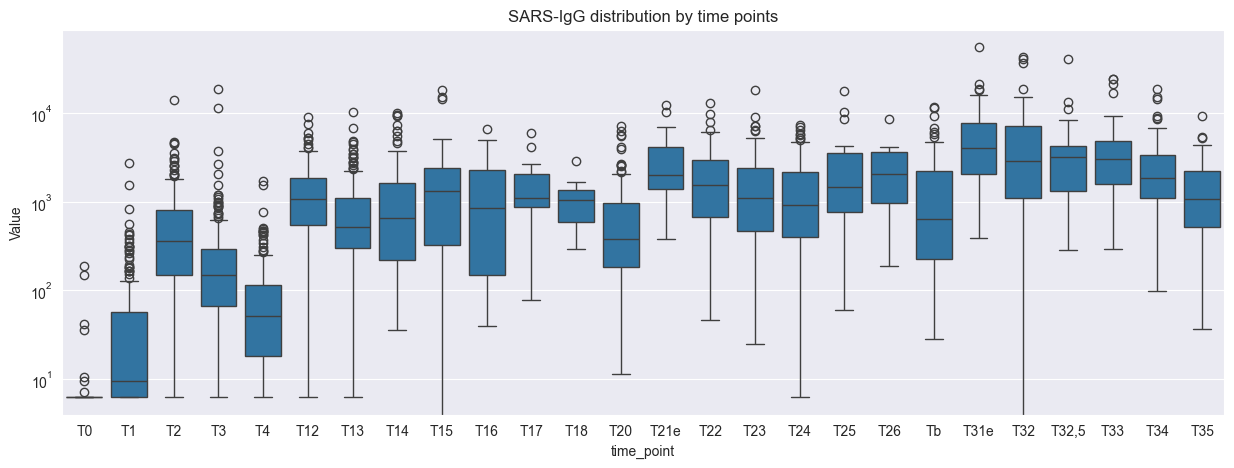

In [16]:
sub_df = target_df.iloc[:, :-1]

sub_df.rename(columns={col: col.split('_')[-1] for col in sub_df.columns}, inplace=True)

plt.figure(figsize=(15, 5))

target_df_melted = pd.melt(sub_df, var_name='time_point', value_name='Value')
# Convert to numeric, coerce errors to NaN
target_df_melted['Value'] = pd.to_numeric(target_df_melted['Value'], errors='coerce')

# Drop rows with NaN in the 'Value' column
target_df_melted = target_df_melted.dropna(subset=['Value'])

# Cast the 'Value' column to integers
target_df_melted['Value'] = target_df_melted['Value'].astype(float)

g = sns.boxplot(data=target_df_melted, x = 'time_point', y ='Value')
g.set_yscale("log")

plt.title('SARS-IgG distribution by time points')